# Quantum Harmonic Oscillator (Continued)
#### Hunter Lybbert
#### Student ID 2426454
#### 11-01-24

In [1]:
from enum import Enum

import numpy as np
import scipy.linalg as la
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

## Repeat HW 2

In [2]:
plt.rcParams['grid.linestyle'] = "--"

In [3]:
def linear_harmonic_oscillator(x: float, y: np.array, epsilon: float) -> np.array:
    return np.array([y[1], (x**2 - epsilon)*y[0]])

def linear_bc_target(x:float, y_0: float, epsilon:float) -> float:
    return np.sqrt(x**2 - epsilon)*y_0

In [4]:
def homework_two_process():
    """
    This encapsulates everything we did in hw two so we don't mess up any namespace weirdness.

    returns solutions A1 and A2
    """
    eigenvalues = []
    eigenvectors = []


    epsilon_initial = 1
    epsilon_diff = 0.1
    y_at_0 = 1
    xshoot = np.arange(-4, 4.1, 0.1)

    for mode in range(1, 6):

        epsilon_current = epsilon_initial
        epsilon_diff = 0.1

        for _ in range(1000):
            bc_start = linear_bc_target(4, y_at_0, epsilon_current)
            y0 = np.array([y_at_0, bc_start])
            sol = solve_ivp(
                fun=linear_harmonic_oscillator,
                t_span=(-4, 4),
                y0=y0,
                method="RK45",
                args=(epsilon_current,),
                dense_output=True
            )

            bc_end = -linear_bc_target(4, sol.y[0, -1], epsilon_current)

            boundary_value_diff = sol.y[1,-1] - bc_end

            if abs(boundary_value_diff) < 1e-6:
                print(epsilon_current)
                eigenvalues.append(epsilon_current)
                break
            
            elif (-1)**(mode + 1)*boundary_value_diff < 0:
                epsilon_current -= epsilon_diff
                epsilon_diff /= 2

            else:
                epsilon_current += epsilon_diff
                
        epsilon_initial = epsilon_current + 0.1

        eigenvector = sol.sol(xshoot)[0, :]
        trap_norm_of_eigenvector = np.trapezoid(eigenvector*eigenvector, xshoot)
        trap_normalized_eigenvector = eigenvector/np.sqrt(trap_norm_of_eigenvector)

        abs_trap_normalized_eigenvector = np.abs(trap_normalized_eigenvector)

        eigenvectors.append(abs_trap_normalized_eigenvector)

        plt.plot(xshoot, abs_trap_normalized_eigenvector, label=rf"$\lambda_{mode}$")
        plt.legend()
        plt.grid()

    plt.show()

    # The abdsolute value of the first 5 eigenfunctions, this should be (81,5)
    A1 = np.vstack(eigenvectors).T
    # The corresponding first 5 eigenvalues, this should be (1,5)
    A2 = np.array(eigenvalues)

    return A1, A2

0.9997357911453946
2.9990026018198495
4.9984630555462
6.99758100515118
8.99625425046196


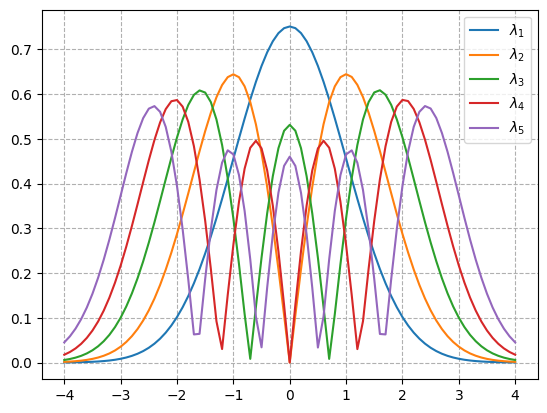

In [5]:
A1, A2 = homework_two_process()

## Actual HW 3


### Part (b)

In [6]:
class DerivativeOrder(Enum):
    second = "second"


class FiniteDifferenceMethod(Enum):
    backward = "backward"
    centered = "centered"
    forward = "forward"


def second_deriv_mat(
    size: int,
    step_size: float,
    order: DerivativeOrder = DerivativeOrder.second,
    difference_method: FiniteDifferenceMethod = FiniteDifferenceMethod.centered
) -> np.array:
    """
    :param size: integer of the shape of the derivative matrix, matrix will be (size, size)
    :param step_size: the size of the delta x in the finite different method
    :param order: the order of derivative bing using

    :returns: the difference matrix requested.
    """
    if order == DerivativeOrder.second:
        if difference_method == FiniteDifferenceMethod.centered:
            deriv_mat = (1/(step_size**2))*(
                np.diag(-2*np.ones(size))
                + np.diag(np.ones(size-1), k=1)
                + np.diag(np.ones(size-1), k=-1)
            )
            return deriv_mat

        else:
            raise ValueError(f"{difference_method.name} is not implimented yet")

    else:
        raise ValueError(f"{order.name} is not implimented yet")
    

def build_bc_matrix(
    derivative_matrix: np.array,
    step_size: float,
) -> np.array:
    """
    :param derivative_matrix: the derivative matrix to create bc matrix like
    :param step_size: the step size need to for helping compute the thing

    :returns: build bc matrix with same shape as deriv matrix
    """
    bc_array = np.array([4/3, -1/3])
    bc_matrix = np.zeros_like(derivative_matrix)

    bc_matrix[0,:2] = bc_array
    bc_matrix[-1,-2:] = bc_array[::-1]
    
    return bc_matrix / step_size**2


def get_n_ordered_eigs(
    eig_values: np.array,
    eig_vectors: np.array,
    num_to_get: int = 5,
    ascending: bool = True,
) -> tuple[np.array, np.array]:
    """
    :param eig_values: used to sort/order eigen values and vectors
    :param eig_vectors: eigenvectors to return the subset of
    :param num_to_get: Number of eigenvalues and eigenvectors to grab
    :param ascending: which way to order them before picking the first n

    :returns: first n eigenvalues and eigenvectors when ordered by prescribed ordering
    """
    sorted_indices = np.argsort(eig_values)

    if ascending:
        subset_eig_values = eig_values[sorted_indices][:num_to_get]
        subset_eig_vectors = eig_vectors[:,sorted_indices][:,:num_to_get]
    else:
        subset_eig_values = eig_values[sorted_indices][:-num_to_get]
        subset_eig_vectors = eig_vectors[:,sorted_indices][:,:-num_to_get]

    return subset_eig_values, subset_eig_vectors


def extend_eigenvector(
    eigenvector: np.array
) -> np.array:
    """
    Extend eigenvector to include the first and last points, using the boundary conditions once again.

    :param eigenvector:

    :return: full eigenvector
    """
    phi_0 = (4/3)*eigenvector[0] - (1/3)*eigenvector[1]
    phi_N = - (1/3)*eigenvector[-2] + (4/3)*eigenvector[-1]
    
    eigenvector = np.append([phi_0], eigenvector)
    eigenvector = np.append(eigenvector, [phi_N])

    return eigenvector


def normalize_eigenvector(
    domain: np.array,
    eigenvector: np.array,
) -> np.array:
    """
    :param domain:
    :param eigenvector:

    :return: normalized eigenvector
    """
    assert domain.size == eigenvector.size, ValueError(f"mismatch dimenstions for normalization between {domain.size} and {eigenvector.size}.")


    norm_of_eig_vec = np.trapezoid(eigenvector*eigenvector, domain)
    normalized_eig_vec = eigenvector/np.sqrt(norm_of_eig_vec)

    return normalized_eig_vec


def plot_eigenfunctions(
    domain: np.array,
    eig_values: np.array,
    eig_vectors: np.array,
) -> None:
    """
    Plot the results of the solve.

    :param domain: the domain to plot over
    :param eig_values: the eigenvalues we calculated
    :param eig_vectors: the corresponding eigenvectors

    Plot these!
    """
    for j, eigenvector in enumerate(eig_vectors):

        plt.plot(domain, eigenvector, label=rf"$\lambda_{j+1}$ = {eig_values[j]:.4f}")
        plt.legend()
        plt.grid()

    plt.show()


def direct_solve_hw_three(
    L: int,
    step_size: int,
    plot_results: bool = True,
    absolute_value: bool = True,
    truncate_imaginary: bool = True,
) -> tuple[np.array, np.array]:
    """
    :param L: The integer representing domain to solve on, will be interpreted to solve on [-L, L]
    :param step_size: the step length to use when discretizing [-L, l]
    :param plot_results: bool indicating desire to see plot
    :param absolute_value: bool whether or not to abs plot and returned eig vectors
    :param truncate_imaginary: bool whether or not to truncate imaginary

    :returns: A one dimensional array of eigenvalues and a matrix where each column is an eigenvector
    """
    x_domain = np.arange(
        start=-L,
        stop=L+step_size,
        step=step_size,
    )
    num_points = x_domain.size

    second_deriv_mat_full = second_deriv_mat(
        size=num_points,
        step_size=step_size,
    )
    second_deriv_mat_truncated = second_deriv_mat_full[1:-1,1:-1]
    bc_matrix = build_bc_matrix(second_deriv_mat_truncated, step_size=step_size)

    domain_truncated = x_domain[1:-1]
    x_squared_mat = np.diag(domain_truncated**2)
    linear_system = -second_deriv_mat_truncated + x_squared_mat - bc_matrix

    eig_values, eig_vectors = la.eig(linear_system)
    first_five_eig_values, first_five_eig_vectors = get_n_ordered_eigs(
        eig_values=eig_values,
        eig_vectors=eig_vectors
    )

    final_eig_vectors = []
    for eig_vec in first_five_eig_vectors.T:
        eig_vec = extend_eigenvector(eig_vec)
        eig_vec = normalize_eigenvector(x_domain, eig_vec)

        final_eig_vectors.append(eig_vec)

    final_eig_vectors = np.vstack(final_eig_vectors)

    if truncate_imaginary:
        first_five_eig_values = np.real(first_five_eig_values)
        
    if absolute_value:
        final_eig_vectors = np.abs(final_eig_vectors)

    if plot_results:
        plot_eigenfunctions(
            domain=x_domain,
            eig_values=first_five_eig_values,
            eig_vectors=final_eig_vectors,
        )
    
    return final_eig_vectors.T, first_five_eig_values

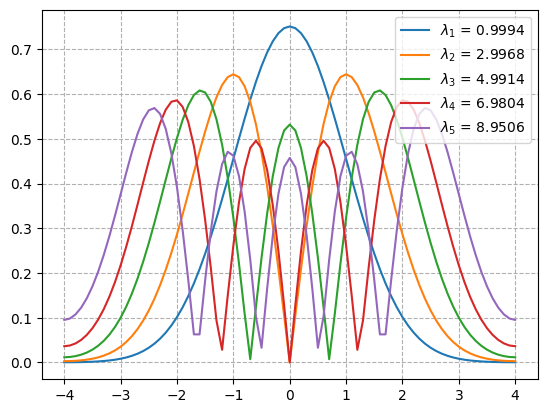

In [7]:
A3, A4 = direct_solve_hw_three(
    L=4,
    step_size=0.1,
    plot_results=True
)

### Part (c)

Now we are looking into how to handle the HArmonic Oscillator with a nonlinear term.
See the following new starting point


Our differential equation is as follows:
$$\frac{\partial^2\phi_n}{\partial x^2} - [\gamma|\phi_n|^2 + Kx^2 - \epsilon_n]\phi_n = 0, \quad x \in [-2, 2]$$

With boundary conditions such that $\phi_n \rightarrow 0$ as $x \rightarrow \pm \infty$.
Let's setup the system of first order differential equations, where $y_0 = \phi_n$ and $y_1 = \phi_n^\prime$

$$
\left[
\begin{align*}
y_0 \\
y_1
\end{align*}
\right]^\prime = \left[
\begin{align*}
y_1 \\
[\gamma|y_0|^2 + Kx^2 - \epsilon_n]y_0
\end{align*}
\right].
$$

Now we need to determine our boundary conditions in a way we can represent it in the program.
We will use the setup from the text, [Data-Driven Modeling & Scientific Computation](https://faculty.washington.edu/kutz/kutz_book_v2.pdf) by J. Nathan Kutz, in _Chapter 8 Section 4: Boundary Value Problems: The Shooting Method_.
Specifically we utilize the equations (15a) and (15b) to get the following boundary conditions:
$$
\begin{align*}
x &= 2: \quad & \frac{\partial \phi_n (2)}{\partial x} &= -\sqrt{\gamma|y_0|^2 + (2)^2 - \epsilon_n}\phi_n(2) &= -\sqrt{\gamma|y_0|^2 + 4 - \epsilon_n}\phi_n(2)\\
x &= -2: \quad & \frac{\partial \phi_n (-2)}{\partial x} &= \sqrt{\gamma|y_0|^2 + (-2)^2 - \epsilon_n}\phi_n(-2) &= \sqrt{\gamma|y_0|^2 + 4 - \epsilon_n}\phi_n(-2)
\end{align*}
$$

In [8]:
def nonlinear_harmonic_oscillator(
    x: float,
    y: np.array,
    epsilon: float,
    gamma: float,
) -> np.array:
    """
    The Linear System used to solve the nonlinear harmonic oscillator

    :param x: domain
    :param y: system of diff eq
    :param epsilon: guess at eigenvalues
    :param gamma: non linearity coeffs

    :returns: the derivative of the system of diff eqs
    """
    y_prime = np.array(
        [
            y[1],
            (gamma*np.abs(y[0])**2 + x**2 - epsilon)*y[0]
        ]
    )
    return y_prime

def nonlinear_bc_target(
    x:float,
    y_0: float,
    epsilon:float,
    gamma: float,
) -> float:
    """
    Organizes our boundary conditions.

    :param x:
    :param y_0:
    :param epsilon:
    :param gamma:

    :returns: The value expected at a boundary given the set of params
    """
    bc = np.sqrt(
        gamma*np.abs(y_0)**2 + x**2 - epsilon
    )*y_0
    return bc

In [9]:
def solve_nonlinear_harmonic_oscillator(
    gamma: float,
    epsilon_initial: float,
    y_0_initial: float,
    L: int = 2,
    step_size: float = 0.1,
    num_eigenvalues: int = 2,
    tol: float = 1e-6,
    epsilon_diff_initial: float = 0.2,
    y_0_diff_initial: float = 0.01,
) -> tuple[np.array, np.array]:
    """
    Solve the same problem from hw 2 but with a nonlinear term added

    :param gamma: the coeffecient of the nonlinear term in the new harmonic oscilator equation (see markdown cell above).
    :param epsilon_initial: initial guess for first eigenvalue
    :param y_0_initial: inital guess for y at the beginning (with no derivative on it)
    :param L: the positibe upper bound of interval will generate an interval of [-L, L]
    :param step_size: the size to incriment the domain we are solving over
    :param num_eigenvalues: the number of eigenvalues to look for
    :param tol: tolerance to solve diff eq using shooting method within
    :param epsilon_diff_initial: The initial steo size as we iterate epsilon in search of eigenvalues
    :param y_0_diff_initial: The initial steo size as we iterate y_0 in search of eigenvalues and eigenfunctions

    :returns: Solution
    """
    eigenvalues = []
    eigenvectors = []

    xshoot = np.arange(-L, L + step_size, step_size)

    for mode in range(1, num_eigenvalues + 1):
        y_0_current = y_0_initial
        y_0_diff = y_0_diff_initial

        for _ in range(100):
            epsilon_current = epsilon_initial
            epsilon_diff = epsilon_diff_initial

            for _ in range(100):
                bc_start = nonlinear_bc_target(L, y_0_current, epsilon_current, gamma=0)
                y0 = np.array([y_0_current, bc_start])
                sol = solve_ivp(
                    fun=nonlinear_harmonic_oscillator,
                    t_span=(-L, L),
                    y0=y0,
                    method="RK45",
                    args=(epsilon_current,gamma,),
                    dense_output=True
                )

                bc_end = -nonlinear_bc_target(
                    L,
                    sol.y[0, -1],
                    epsilon_current,
                    gamma=0
                )
                boundary_value_diff = sol.y[1,-1] - bc_end

                if abs(boundary_value_diff) < tol:
                    break
                
                elif (-1)**(mode + 1)*boundary_value_diff < 0:
                    epsilon_current -= epsilon_diff
                    epsilon_diff /= 2

                else:
                    epsilon_current += epsilon_diff

            eigenvector = sol.sol(xshoot)[0, :]
            
            area = np.trapezoid(eigenvector**2,xshoot)
            if np.abs(area - 1) < tol:
                eigenvalues.append(epsilon_current)
                break
            
            elif area < 1:
                y_0_current += y_0_diff
            
            else:
                y_0_current -= y_0_diff
                y_0_diff /= 2
                
        epsilon_initial = epsilon_current + 0.2

        eigenvector = sol.sol(xshoot)[0, :]
        abs_eigenvector = np.abs(eigenvector)
        eigenvectors.append(abs_eigenvector)

        plt.plot(xshoot, abs_eigenvector, label=rf"$\lambda_{mode}$ = {epsilon_current:.4f}")
        plt.title(rf"$\gamma$ = {gamma}")
        plt.legend()
        plt.grid()

    plt.show()

    # The abdsolute value of the first 5 eigenfunctions, this should be (int(np.round((2L + step_size)/step_size)), n)
    eigenvectors_final_res = np.vstack(eigenvectors).T
    # The corresponding first n eigenvalues, this should be (n,)
    eigenvalues_final_res = np.array(eigenvalues)

    return eigenvectors_final_res, eigenvalues_final_res

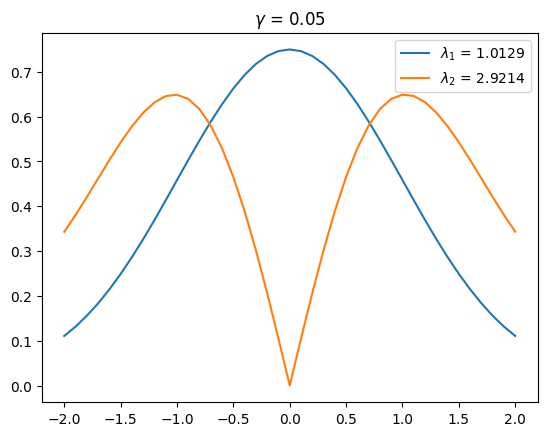

In [10]:
A5, A6 = solve_nonlinear_harmonic_oscillator(
    gamma=0.05,
    epsilon_initial=1,
    y_0_initial=1e-6,
    tol=1e-4,
)

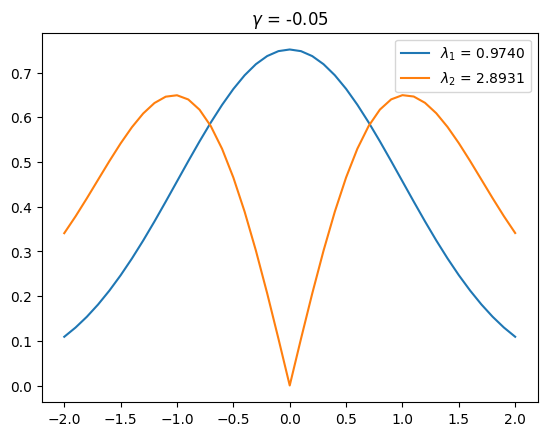

In [11]:
A7, A8 = solve_nonlinear_harmonic_oscillator(
    gamma=-0.05,
    epsilon_initial=1,
    y_0_initial=1e-6,
    tol=1e-4,
)

### Part (d): Convergence Study

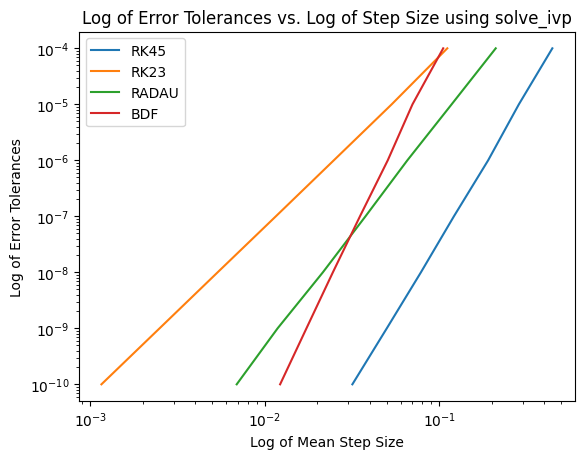

In [12]:
class SolveIVPMethod(Enum):
    rk45 = 'RK45'
    rk23 = 'RK23'
    radau = 'Radau'
    bdf = 'BDF'


def mean_step_size_using_solve_ivp(
    solve_method: SolveIVPMethod,
    tols: list[float],
    epsilon: float = 1,
    y0: float = 1,
    L: int = 2,
) -> np.array:
    """
    Setting up the convergence study

    :returns: The mean step size array across the various values of tolerance
    """
    mean_step_size = []
    bc_start = linear_bc_target(L, y0, epsilon)
    y0 = np.array([y0, bc_start])
    for tol in tols:
        options = {'rtol': tol, 'atol': tol}
        sol = solve_ivp(
            fun=linear_harmonic_oscillator,
            t_span=(-L, L),
            y0=y0,
            method=solve_method.value,
            args=(epsilon,),
            dense_output=True,
            **options
        )
        mean_step_size.append(np.mean(np.diff(sol.t)))

    return np.array(mean_step_size)


def get_slope_from_polyfit_on_loglog_data(
    x:np.array,
    y: np.array,
    deg: int = 1,
) -> float:
    """
    Take log of data and fit line to it.

    :returns: slope
    """
    log_x = np.log(x)
    log_y = np.log(y)
    result = np.polyfit(log_x, log_y, deg=deg)

    return result[0]

def convergence_study():
    """
    Run the convergence study

    :returns: The requisite array of slopes
    """
    slopes = []
    tols_list = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

    for solve_method in SolveIVPMethod:
        mean_step_size_array = mean_step_size_using_solve_ivp(
            solve_method=solve_method,
            tols=tols_list,
        )
        slope = get_slope_from_polyfit_on_loglog_data(
            mean_step_size_array, tols_list
        )
        slopes.append(slope)

        plt.loglog(mean_step_size_array, tols_list, label=f"{solve_method.name.upper()}")

    plt.xlabel("Log of Mean Step Size")
    plt.ylabel("Log of Error Tolerances")
    plt.title("Log of Error Tolerances vs. Log of Step Size using solve_ivp")
    plt.legend()
    plt.show()

    return np.array(slopes)

A9 = convergence_study()

### Part (e) Compare Results
From wikipedia, [Quantum Harmonic Oscillator](https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator), we get th following analytic solution

$$
\psi_n(x) = \frac 1 {\sqrt{2^n n!}} \frac 1 {\sqrt[4]{\pi}} {\rm e}^{\frac {-x^2} 2} H_n(x)
$$
where $H_n(x)$ is given by
$$
H_n(x) = (-1)^n {\rm e}^{x^2} \frac {d^n}{dx^n} \left({\rm e}^{-x^2}\right).
$$

In [13]:
def hermite(n: int) -> callable:
    """
    Define the first n hermite functions
    """
    H_0 = lambda x: 1
    H_1 = lambda x: 2*x
    H_2 = lambda x: 4*x**2 - 2
    H_3 = lambda x: 8*x**3 - 12*x
    H_4 = lambda x: 16*x**4 - 48*x**2 + 12

    return [H_0, H_1, H_2, H_3, H_4][n]


def fact(n: int) -> int:
    """
    This is just a factorial helper function used for gradscope compatability
    """
    if n < 0:
        raise ValueError(f"This factorial helper is not built to handle negative integers like {n}")
    if n > 1:
        return n*fact(n - 1)
    else:
        return 1


def gauss_hermite_ground_truth(x: np.array, n: int) -> np.array:
    """
    Use the Gauss Hermite analytic solution to calculate the ground truths.

    :param x: the domain to evaluate the nth gauss hermite solution
    :param n: the nth gauss ehrmite solution to evaluate

    For more information see https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator
    """
    return 1/np.sqrt(fact(n) * 2**n * np.sqrt(np.pi)) * hermite(n)(x) * np.exp(-(x**2)/2)


In [14]:
def compute_errors(
    domain: np.array,
    computed_eigenvectors: np.array,
    computed_eigenvalues: np.array,
) -> tuple[np.array, np.array]:
    """
    Calculate errors based on exact analytical solution.

    :param domain: the common domain to compute the error over
    :param computed_eigenvectors: the eigenvectors found numerically
    :param computed_eigenvalues: the eigenvalues found numerically

    :returns: Errors in the form of 2 one dimensional arrays
    """
    eigenvector_error = []
    eigenvalue_error = []

    for j in range(len(computed_eigenvectors)):
        
        diff = abs(computed_eigenvectors[j]) - abs(gauss_hermite_ground_truth(x=domain, n=j))
        norm = np.trapezoid(diff*diff, domain)

        percent_diff = 100*np.abs(computed_eigenvalues[j] - (2*j + 1))/(2*j + 1)

        eigenvector_error.append(norm)
        eigenvalue_error.append(percent_diff)

    eigenvector_error = np.array(eigenvector_error)
    eigenvalue_error = np.array(eigenvalue_error)

    return eigenvector_error, eigenvalue_error

In [15]:
domain = np.arange(-4, 4.1, .1)

A10, A11 = compute_errors(
    domain=domain,
    computed_eigenvectors=A1.T,
    computed_eigenvalues=A2,
)

A12, A13 = compute_errors(
    domain=domain,
    computed_eigenvectors=A3.T,
    computed_eigenvalues=A4,
)

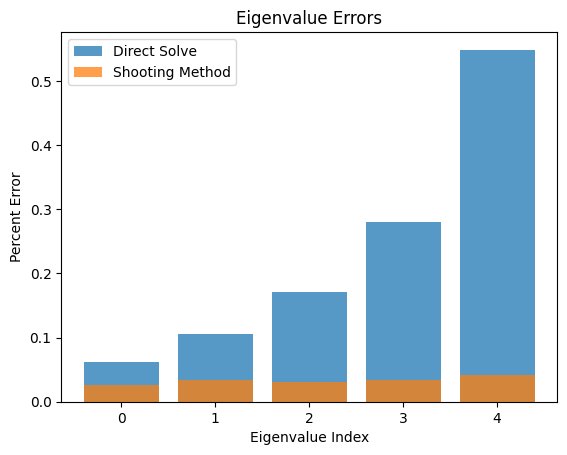

In [16]:
plt.bar(np.arange(5), A13, alpha=0.75, label="Direct Solve")
plt.bar(np.arange(5), A11, alpha=0.75, label="Shooting Method")
plt.title("Eigenvalue Errors")
plt.ylabel("Percent Error")
plt.xlabel("Eigenvalue Index")
plt.legend()
plt.show()

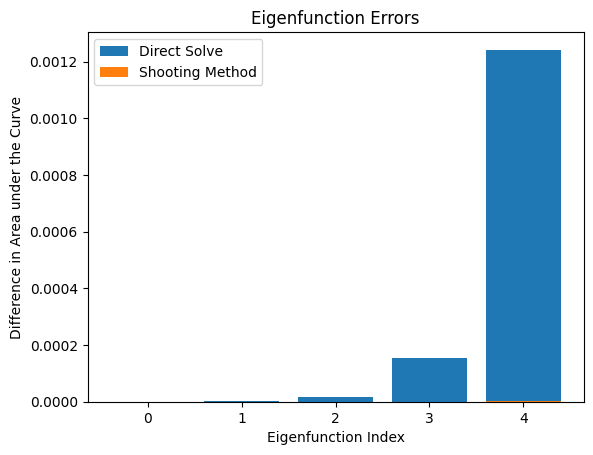

In [17]:
plt.bar(np.arange(5), A12, label="Direct Solve")
plt.bar(np.arange(5), A10, label="Shooting Method")
plt.title("Eigenfunction Errors")
plt.ylabel("Difference in Area under the Curve")
plt.xlabel("Eigenfunction Index")
plt.legend()
plt.show()